<a href="https://colab.research.google.com/github/caroldaza/DM_CyT/blob/main/smallworldofwords_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [3]:
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

import numpy as np
import pandas as pd   

!pip install networkx powerlaw community

import networkx as nx
import community
import powerlaw
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from sklearn.metrics import adjusted_rand_score

In [4]:
filename = '/content/drive/MyDrive/SWOW-EN.R100.csv.zip'
datos = pd.read_csv(filename, sep=',')
datos.head()

,Unnamed: 0,id,participantID,age,gender,nativeLanguage,country,education,created_at,cue,R1,R2,R3
0,1,29,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,although,nevertheless,yet,but
1,2,30,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,deal,no,cards,shake
2,3,31,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,music,notes,band,rhythm
3,4,32,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,inform,tell,rat on,NaN
4,5,33,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,way,path,via,method


In [10]:
# Nos quedamos solo con la cue y la primera palabra. Tambien botamos Nans
data = datos.loc[:,['cue','R1']]
data = data.dropna(how='any')

# Sacar palabras de una letra
data.drop(data[data['cue'].str.len().lt(2)].index, inplace=True)
data.drop(data[data['R1'].str.len().lt(2)].index, inplace=True)

data.head()

,cue,R1
0,although,nevertheless
1,deal,no
2,music,notes
3,inform,tell
4,way,path


In [12]:
data.shape[0]

1194119

In [6]:
# ¿Cuántas claves y respuestas son únicas?
print(data['cue'].unique().shape)
print(data['R1'].unique().shape)

(12258,)
(64663,)


In [7]:
# ¿cuántas palabras de R1 están en Cue? ¿alrevés?
print(sum(data['R1'].isin(data['cue'].unique())))
print(sum(data['cue'].isin(data['R1'].unique())))

1067977
1185365


In [11]:
# Sacar palabras que no este en cue Y en R1
data.drop(data[data['R1'].isin(data['cue'].unique())==False].index, inplace=True)
data.drop(data[data['cue'].isin(data['R1'].unique())==False].index, inplace=True)

In [16]:
data.shape[0]

1060109

In [17]:
# la frecuencia de cada cue
new_df = data['cue'].str.split(expand=True).stack().value_counts().reset_index()
new_df.columns = ['Word', 'Frequency'] 

In [18]:
new_df

,Word,Frequency
0,up,2021
1,not,1167
2,out,1061
3,on,961
4,down,830
...,...,...
11868,ping,33
11869,Homer,29
11870,adrenal,26
11871,Sherlock,23


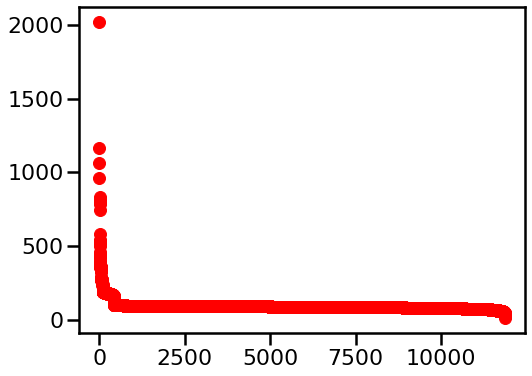

In [19]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.plot(new_df['Frequency'],'ro')

Text(0, 0.5, 'frequency')

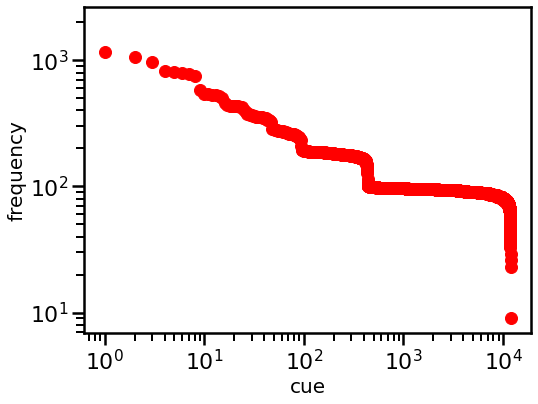

In [21]:
#plt.loglog(np.linspace(1, len(new_df['Frequency']),len(new_df['Frequency'])),new_df['Frequency'].to_numpy())
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(new_df['Frequency'],'ro')
plt.xlabel("cue",fontsize=20)
plt.ylabel("frequency",fontsize=20)

In [23]:
# la frecuencia de cada R1
new_df_R1 = data['R1'].str.split(expand=True).stack().value_counts().reset_index()
new_df_R1.columns = ['Word', 'Frequency'] 

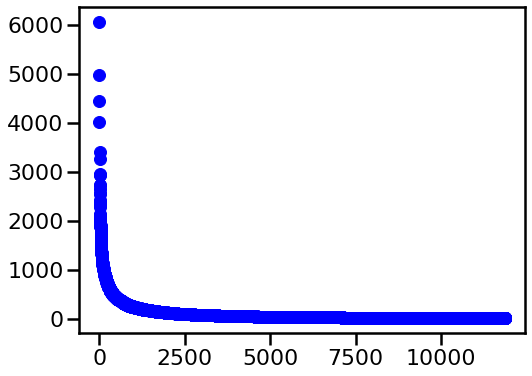

In [24]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.plot(new_df_R1['Frequency'],'bo')

Text(0, 0.5, 'frequency')

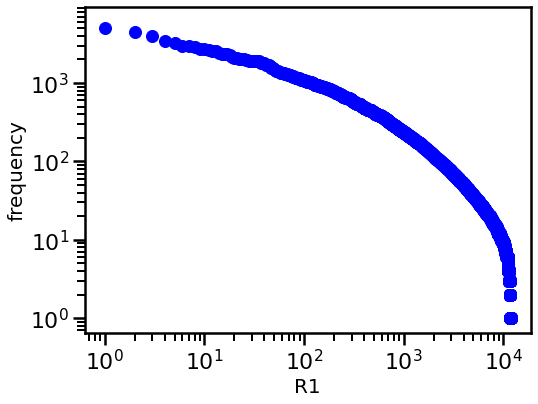

In [26]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(new_df_R1['Frequency'],'bo')
plt.xlabel("R1",fontsize=20)
plt.ylabel("frequency",fontsize=20)

In [12]:
#sacando los duplicados
data_0 = data[data.duplicated()]
print(data_0.shape[0])

674293


In [10]:
# calculando frecuencia de aparicion de cada cue
df1_0 = data_0.groupby(['cue']).size().to_frame(name='size').reset_index()
df1_0_sorted = df1_0.sort_values(by=['size'],ascending=False).reset_index()
df1_0_sorted.head(5)

,index,cue,size
0,62,Cheddar,92
1,7129,mozzarella,92
2,7059,moo,91
3,1909,cardiac,91
4,304,Sahara,91


In [11]:
# calculando frecuencia de aparicion de R1
df3_0 = data_0.groupby(['R1']).size().to_frame(name='size').reset_index()
df3_0_sorted = df3_0.sort_values(by=['size'],ascending=False).reset_index()
df3_0_sorted.head(5)

,index,R1,size
0,6499,money,5166
1,4149,food,3883
2,10915,water,3630
3,1760,car,3305
4,6619,music,2794


In [12]:
# calculando frecuencia de aparicion de cada par cue-R1
df2_0 = data_0.groupby(['cue','R1']).size().to_frame(name='size').reset_index()
df2_0_sorted = df2_0.sort_values(by=['size'],ascending=False).reset_index()
df2_0_sorted.head(5)

,index,cue,R1,size
0,591,Cheddar,cheese,92
1,2523,Parmesan,cheese,91
2,76260,moo,cow,90
3,55638,halt,stop,86
4,77017,mozzarella,cheese,85


In [13]:
df_0 = df2_0.merge(df1_0,left_on='cue',right_on='cue')
df_0 = df_0.rename(columns={'size_x':'frec_par','size_y':'frec_cue'})
df_0['frec'] = df_0['frec_par']/df_0['frec_cue']
df_0.head(5)

,cue,R1,frec_par,frec_cue,frec
0,Abel,Cain,54,59,0.915254
1,Abel,can,1,59,0.016949
2,Abel,cane,3,59,0.050847
3,Abel,religion,1,59,0.016949
4,Aboriginal,Australia,28,70,0.400000


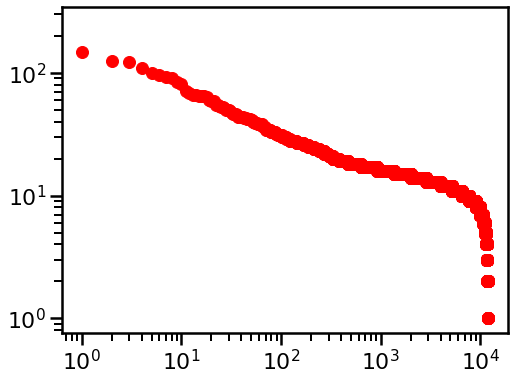

In [102]:
auxc = df_0['cue'].str.split(expand=True).stack().value_counts().reset_index()
auxc.columns = ['Word', 'Frequency'] 
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(auxc['Frequency'],'ro')

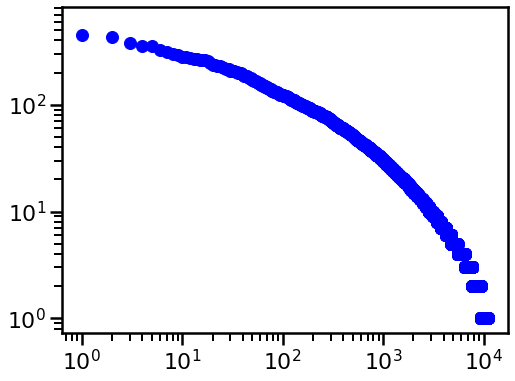

In [107]:
auxp = df_0['R1'].str.split(expand=True).stack().value_counts().reset_index()
auxp.columns = ['Word', 'Frequency'] 
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(auxp['Frequency'],'bo')

In [14]:
df1_0 = df_0[['cue']].rename(columns={'cue':'word'},inplace=False) #dejando solo la palabra
df2_0 = df_0[['R1']].rename(columns={'R1':'word'},inplace=False)

df_0_dict = pd.concat([df1_0,df2_0])  # concatenando
list_dict_0 = df_0_dict['word'].unique() #eliminando duplicados
list_dict_0.shape

(12165,)

In [15]:
print('numero nodos',len(list_dict_0))
print('numero maximo aristas (no dirigidas y sin loops)',len(list_dict_0)*(len(list_dict_0)-1)/2)
print('numero maximo aristas (dirigidas y sin loops)',len(list_dict_0)*(len(list_dict_0)-1))
print('numero maximo aristas (dirigidas y con loops)',len(list_dict_0)*(len(list_dict_0)))

numero nodos 12165
numero maximo aristas (no dirigidas y sin loops) 73987530.0
numero maximo aristas (dirigidas y sin loops) 147975060
numero maximo aristas (dirigidas y con loops) 147987225


El grafo:

In [15]:
G1 = nx.from_pandas_edgelist(data_0[['cue','R1']],source='cue',target='R1',edge_attr=None)

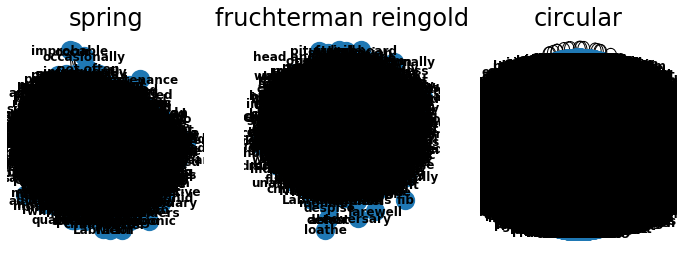

In [16]:
#Visualizando la red

plt.figure(figsize=(12,4))

plt.subplot(131)
nx.draw(G1, with_labels=True, font_weight='bold')
plt.title('spring')

plt.subplot(132)
layout=nx.fruchterman_reingold_layout(G1)
nx.draw(G1,layout, with_labels=True, font_weight='bold')
plt.title('fruchterman reingold')

plt.subplot(133)
layout=nx.circular_layout(G1)
nx.draw(G1,layout, with_labels=True, font_weight='bold')
plt.title('circular');



Esta fue la red sin sacar las palabras de w2v

# Comparando con las palabras de word2vec

In [17]:
# cargamos word2vec
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

w2v_model2 = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

--2021-12-11 04:25:44--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.229.240
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.229.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz.1’

GoogleNews-vectors- 100%[===================>]   1.53G  29.8MB/s    in 33s     

2021-12-11 04:26:17 (47.8 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz.1’ saved [1647046227/1647046227]



In [18]:
# sacar palabras que no esten en w2v
l = [w for w in data['cue'] if w not in w2v_model2.vocab]
data_f = data[-data['cue'].isin(l)]
print(data_f.shape[0]) 

1025915


In [19]:
l = [w for w in data_f['R1'] if w not in w2v_model2.vocab]
data_f = data_f[-data_f['R1'].isin(l)]
print(data_f.shape[0])

1016391


In [20]:
#sacando los duplicados
data_f = data_f[data_f.duplicated()]
print(data_f.shape[0])

647788


#Frecuencia de aparicion de pares

In [21]:
# calculando frecuencia de aparicion de cada cue
df1 = data_f.groupby(['cue']).size().to_frame(name='size').reset_index()
df1_sorted = df1.sort_values(by=['size'],ascending=False).reset_index()
df1_sorted.head(5)

,index,cue,size
0,61,Cheddar,92
1,6881,mozzarella,92
2,6376,lyrics,91
3,267,Sahara,91
4,239,Parmesan,91


In [22]:
# calculando frecuencia de aparicion de cada par cue-R1
df2 = data_f.groupby(['cue','R1']).size().to_frame(name='size').reset_index()
df2_sorted = df2.sort_values(by=['size'],ascending=False).reset_index()
df2_sorted.head(5)

,index,cue,R1,size
0,566,Cheddar,cheese,92
1,2131,Parmesan,cheese,91
2,72731,moo,cow,90
3,52966,halt,stop,86
4,73459,mozzarella,cheese,85


In [23]:
df = df2.merge(df1,left_on='cue',right_on='cue')
df = df.rename(columns={'size_x':'frec_par','size_y':'frec_cue'})
df['frec'] = df['frec_par']/df['frec_cue']
df.head(5)

,cue,R1,frec_par,frec_cue,frec
0,Abel,Cain,54,59,0.915254
1,Abel,can,1,59,0.016949
2,Abel,cane,3,59,0.050847
3,Abel,religion,1,59,0.016949
4,Aboriginal,Australia,28,70,0.400000


In [24]:
# Recortando el grafo

df = df[(df['frec_par'] > 5) & (df['frec_cue'] > 10)]

# Sacar palabras que no estan mas en el cue y la R1
df.drop(df[df['R1'].isin(df['cue'].unique())==False].index, inplace=True)
df.drop(df[df['cue'].isin(df['R1'].unique())==False].index, inplace=True)
print(df.shape[0])

15735


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
df1 = df[['cue']].rename(columns={'cue':'word'},inplace=False) #dejando solo la palabra
df2 = df[['R1']].rename(columns={'R1':'word'},inplace=False)

df_dict = pd.concat([df1,df2])  # concatenando
list_dict = df_dict['word'].unique() #eliminando duplicados
list_dict.shape

(6039,)

In [26]:
print('numero nodos',len(list_dict))
print('numero maximo aristas (no dirigidas y sin loops)',len(list_dict)*(len(list_dict)-1)/2)
print('numero maximo aristas (dirigidas y sin loops)',len(list_dict)*(len(list_dict)-1))
print('numero maximo aristas (dirigidas y con loops)',len(list_dict)*(len(list_dict)))

numero nodos 6039
numero maximo aristas (no dirigidas y sin loops) 18231741.0
numero maximo aristas (dirigidas y sin loops) 36463482
numero maximo aristas (dirigidas y con loops) 36469521


#Distancias matrices w2v

Hacemos la matriz de distancias de todas contra todas

In [ ]:
distancias_w2v_dict=np.zeros((len(list_dict),len(list_dict))) #matriz cuadrada
t = time.time()
print('Total de pares de palabras %d'%(len(list_dict)*(len(list_dict)-1)/2))
for i,ti in enumerate(list_dict):
  if i % 1000 ==0:
    print('Palabra %d: %.2f secs'%(i,time.time()-t))
  for j,tj in enumerate(list_dict):
    if j>i:
      distancias_w2v_dict[i,j] = abs(1-w2v_model2.similarity(ti,tj))


In [65]:
distancias_w2v_dict = distancias_w2v_dict + distancias_w2v_dict.T
print(distancias_w2v_dict.shape)

(6039, 6039)


In [66]:
distancias_w2v_dict

array([[ 0.        , 11.92243862, 16.63910902, ..., 16.14626747,
        16.43348891, 15.41937202],
       [11.92243862,  0.        , 15.0837127 , ..., 16.8138091 ,
        16.32715365, 14.03631067],
       [16.63910902, 15.0837127 ,  0.        , ..., 14.13450813,
        17.29680693, 12.63237929],
       ...,
       [16.14626747, 16.8138091 , 14.13450813, ...,  0.        ,
        13.9512105 ,  8.91893196],
       [16.43348891, 16.32715365, 17.29680693, ..., 13.9512105 ,
         0.        , 15.16745335],
       [15.41937202, 14.03631067, 12.63237929, ...,  8.91893196,
        15.16745335,  0.        ]])

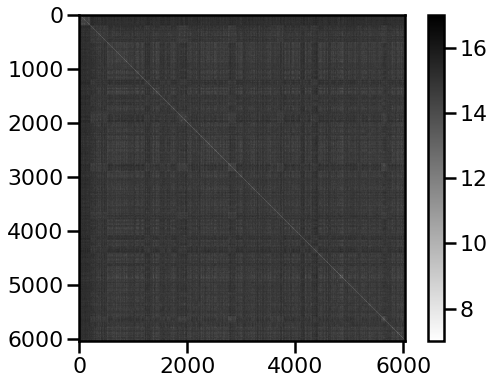

In [70]:
plt.imshow(distancias_w2v_dict,cmap='gray_r',vmax=17,vmin=7)
plt.colorbar()

Son muchos elementos, pero haciendo un zoom, se ven algunos conjuntos de nodos mas cercanos

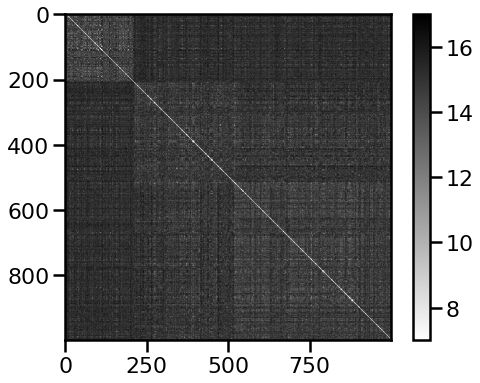

In [78]:
distancia_peque = distancias_w2v_dict[0:1000,0:1000]
plt.imshow(distancia_peque,cmap='gray_r',vmax=17,vmin=7)
plt.colorbar()

(7.0, 19.0)

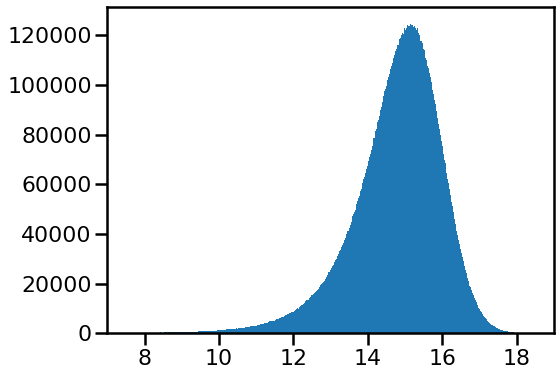

In [84]:
#El histograma de distancias
out = plt.hist(distancias_w2v_dict.flatten(),bins='auto')
plt.xlim([7,19])

El grafo:

In [28]:
G2 = nx.from_pandas_edgelist(df[['cue','R1','frec']],source='cue',target='R1',edge_attr=True)

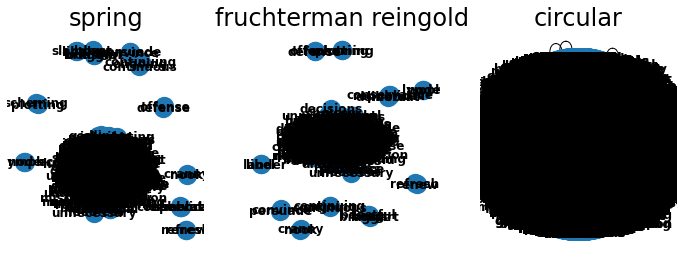

In [29]:
#Visualizando la red

plt.figure(figsize=(12,4))

plt.subplot(131)
nx.draw(G2, with_labels=True, font_weight='bold')
plt.title('spring')

plt.subplot(132)
layout=nx.fruchterman_reingold_layout(G2)
nx.draw(G2,layout, with_labels=True, font_weight='bold')
plt.title('fruchterman reingold')

plt.subplot(133)
layout=nx.circular_layout(G2)
nx.draw(G2,layout, with_labels=True, font_weight='bold')
plt.title('circular');

Este es el grafo sin las palabras de w2v. Hay que hacer uno para las palabras del dataset que si estan en w2v

In [ ]:
results = powerlaw.Fit(new_df['Frequency'])
results.power_law.alpha
results.power_law.sigma
results.distribution_compare('power_law', 'exponential')

In [ ]:
figPDF = results.plot_pdf(color='r', linewidth=2)
results.power_law.plot_pdf(color='r', linestyle='--', ax=figPDF)

####
figPDF.set_ylabel(u"p(X)")
figPDF.set_xlabel(r"Cue Frequency")

In [ ]:
results_R1 = powerlaw.Fit(new_df_R1['Frequency'])
results_R1.power_law.alpha
results_R1.power_law.sigma
results_R1.distribution_compare('power_law', 'exponential')

In [ ]:
figPDF = results_R1.plot_pdf(color='b', linewidth=2)
results_R1.power_law.plot_pdf(color='b', linestyle='--', ax=figPDF)

####
figPDF.set_ylabel(u"p(X)")
figPDF.set_xlabel(r"R1 Frequency")